In [59]:
# Core imports
import pandas as pd
import morfeusz2
import re
import string
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from joblib import dump


In [60]:
morf = morfeusz2.Morfeusz()

def LowerCase(text: str) -> str:
    """Converts letters in given text to lowercase.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Lowercase text.

    """
    preprocessedText = str.lower(text)
    return  preprocessedText

def RemoveHashtags(text: str) -> str:
    """Removes hashtags from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no hashtags.

    """
    preprocessedText = re.sub('#[a-zA-Z0-9_]+', '', text )

    return preprocessedText

def RemoveMentions(text: str) -> str:
    """Removes mentions from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no mentions.

    """
    preprocessedText = re.sub('@[a-zA-Z0-9_]+', '', text )

    return preprocessedText

def RemovePunctuation(text: str) -> str:
    """Removes non text characters from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no non tex characters.

    """
    preprocessedText = text.translate(str.maketrans('', '', string.punctuation))

    return preprocessedText

def Lemmatize(text: str) -> str:
    """Lemmatizes polish text from given tweet.
    Args:
        text (str): Text to preprocess.
    Returns:
        lemmatizedText (str): Lemmatized text.

    """
    wordList = text.split()
    lemmatizedWordList = []

    for word in wordList:    
        _, _, interpretation = morf.analyse(word)[0]
        lemWord = interpretation[1]
        lemWordStripped = lemWord.split(':', 1)[0].lower()
        lemmatizedWordList.append(lemWordStripped)

    lemmatizedText = ' '.join(lemmatizedWordList)

    return lemmatizedText

def RemoveStopWords(text: str) -> str:
    """Removes stopwords.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no stopwords.

    """
    wordList = text.split() 
    preprecessedWordList = []

    stopWords = stopwords.words('polish')
    stopWords += ['rt']

    for word in wordList:
        if word not in stopWords:
            preprecessedWordList.append(word)

    preprocessedText = ' '.join(preprecessedWordList)

    return preprocessedText

In [61]:
# Loading tweet data

data = pd.read_csv('../data/tweets.csv')

In [62]:
# Data preprocess
data.tweet = data.tweet.apply(lambda x: RemoveHashtags(x))
data.tweet = data.tweet.apply(lambda x: RemoveMentions(x))
data.tweet = data.tweet.apply(lambda x: RemovePunctuation(x))
data.tweet = data.tweet.apply(lambda x: Lemmatize(x))
data.tweet = data.tweet.apply(lambda x: RemoveStopWords(x))
data.tweet = data.tweet.apply(lambda x: LowerCase(x))

In [63]:
# Machine learning imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [64]:
# Creating vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=10)
features = vectorizer.fit_transform(data.tweet)

xTrain, xTest, yTrain, yTest = train_test_split(features, data.label)

dump(vectorizer, '../app/models/vectorizer.joblib') 

['../app/models/vectorizer.joblib']

In [65]:
# Creating SVC model
params = {'C': [1000, 3000, 9000, 15000]}
svc = GridSearchCV(SVC(kernel='rbf', gamma='auto'), param_grid=params, scoring='f1', cv=3, n_jobs=-1)
svc.fit(xTrain, yTrain)

print("Best parameters found were {} with F1 score of {:.3f}".format(
    svc.best_params_,
    svc.best_score_
))

dump(svc, '../app/models/svc.joblib') 

Best parameters found were {'C': 15000} with F1 score of 0.324


['../app/models/svc.joblib']

Model test:
		Prec: 0.3657142857142857         
		 Rec: 0.3047619047619048         
		 F1: 0.3324675324675325         
		 Acc: 0.8976503385105535         
		 ROC_AUC: 0.6282610045321909


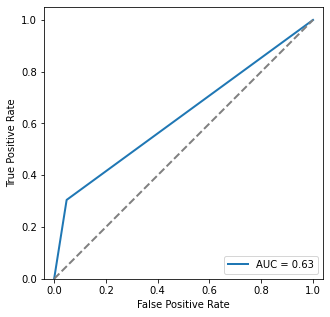

In [66]:
# Testing model and create plots
print('Model test:')
predictions = svc.predict(xTest)
print(f'\t\tPrec: {metrics.precision_score(yTest, predictions)} \
        \n\t\t Rec: {metrics.recall_score(yTest, predictions)} \
        \n\t\t F1: {metrics.f1_score(yTest, predictions)} \
        \n\t\t Acc: {metrics.accuracy_score(yTest, predictions)} \
        \n\t\t ROC_AUC: {metrics.roc_auc_score(yTest, predictions)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(yTest, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()